In [46]:
import pandas as pd
from tqdm import tqdm

df = pd.read_excel("preprocessed.xlsx")
columns_ignore = ['name', 'released', 'score', 'votes', 'gross', 'same_year']


In [50]:
wonka = df.iloc[-1]
# remove wonka from df
df = df.iloc[:-1]
wonka = wonka.drop(columns_ignore)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=1, interaction_only=True, include_bias=False)

X = df.drop(
    columns_ignore,
    axis=1,
)
X = poly.fit_transform(X)
y = df["score"]

X, X_test_final, y, y_test_final = train_test_split(X, y, test_size=0.2, random_state=42)

# Models

In [11]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt


def plot_predictions(y_test, y_pred):
    plt.scatter(y_test, y_pred, color="blue")
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title("Predictions vs. Truth")
    plt.show()


def evaluate(model, X, y):
    pred = model.predict(X)
    print("Mean squared error: %.2f" % mean_squared_error(y, pred))
    print("Mean absolute error: %.2f" % mean_absolute_error(y, pred))
    print("Coefficient of determination: %.2f" % r2_score(y, pred))
    plot_predictions(y, pred)

In [12]:
models = []

## LinearRegression

In [13]:
from sklearn.linear_model import LinearRegression

linear_models = []
for i in tqdm(range(30)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    linear_regressor = LinearRegression()
    linear_regressor = linear_regressor.fit(X_train, y_train)

    linear_models.append(((f"linreg{i}", linear_regressor), mean_squared_error(y_test, linear_regressor.predict(X_test))))

# add the top 10 linear models to the list of models
linear_models.sort(key=lambda x: x[1])
for model in linear_models[:10]:
    models.append(model[0])

100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Mean squared error: 0.59
Mean absolute error: 0.58
Coefficient of determination: 0.37


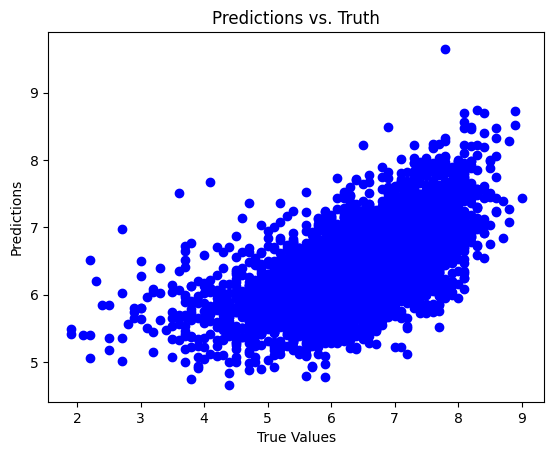

Mean squared error: 0.60
Mean absolute error: 0.58
Coefficient of determination: 0.36


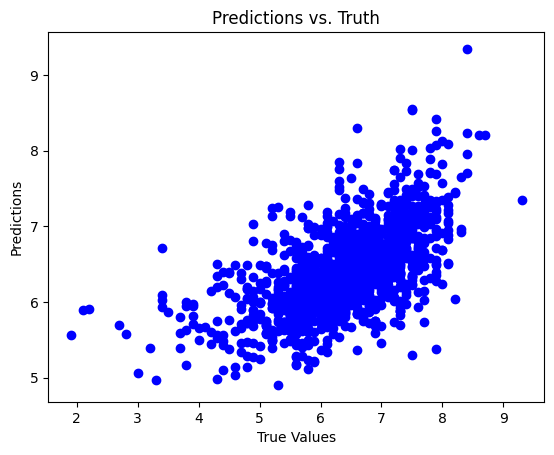

In [14]:
evaluate(linear_regressor, X_train, y_train)
evaluate(linear_regressor, X_test, y_test)

## DecisionTree

In [15]:
from sklearn.tree import DecisionTreeRegressor

decision_tree_models = []
for max_leaf_nodes in tqdm(range(2, 10, 2)):
    for max_depth in range(1, 10, 2):
        for criterion in ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
            decision_tree = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes**2, max_depth=max_depth**2, criterion=criterion)
            decision_tree = decision_tree.fit(X_train, y_train)

            decision_tree_models.append(((f"dt{max_leaf_nodes},{max_depth},{criterion}", decision_tree), mean_squared_error(y_test, decision_tree.predict(X_test))))
    
# add the top 10 decision tree models to the list of models
decision_tree_models.sort(key=lambda x: x[1])
for model in decision_tree_models[:10]:
    models.append(model[0])

100%|██████████| 4/4 [01:15<00:00, 18.93s/it]


Mean squared error: 0.58
Mean absolute error: 0.58
Coefficient of determination: 0.36


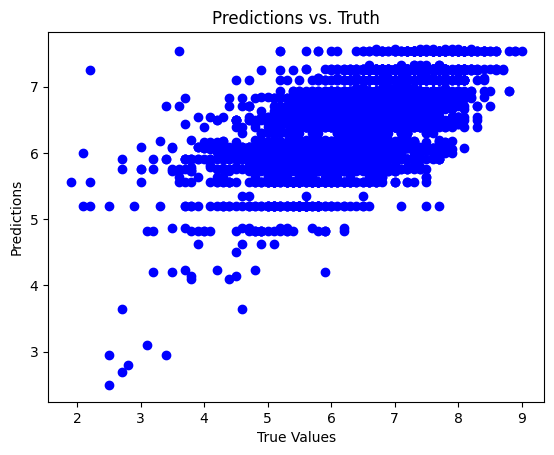

Mean squared error: 0.78
Mean absolute error: 0.67
Coefficient of determination: 0.24


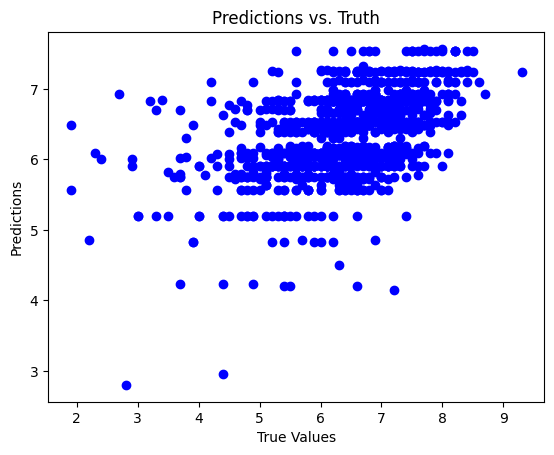

In [16]:
evaluate(decision_tree, X_train, y_train)
evaluate(decision_tree, X_test, y_test)

## Forest Regressor

In [18]:
from sklearn.ensemble import RandomForestRegressor
import random

n_iters = 0

forest_models = []

hyperparameters = set()
for max_depth in random.sample(range(1, 11), 3):
    # n_estimators
    for n_estimators in random.sample(range(50, 500), 5):
        # max_features
        for max_features in random.sample(range(1, 11), 3):
            # min_samples_split
            for min_samples_split in random.sample(range(2, 11), 3):
                # min_samples_leaf
                for min_samples_leaf in random.sample(range(1, 11), 3):
                    hyperparameters.add((max_depth, n_estimators, max_features, min_samples_split, min_samples_leaf))

for i in range(1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    forest = RandomForestRegressor()
    forest = forest.fit(X_train, y_train)

    for max_depth, n_estimators, max_features, min_samples_split, min_samples_leaf in tqdm(hyperparameters):
        forest = RandomForestRegressor(
            max_depth=max_depth*2,
            n_estimators=n_estimators,
            max_features=max_features*3,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
        )
        forest = forest.fit(X_train, y_train)
        n_iters += 1
        forest_models.append(((f"forest{n_iters}", forest), mean_squared_error(y_test, forest.predict(X_test))))

for i in tqdm(range(10)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    forest = RandomForestRegressor()
    forest = forest.fit(X_train, y_train)
    n_iters += 1
    forest_models.append(((f"forest{n_iters}", forest), mean_squared_error(y_test, forest.predict(X_test))))

# add the top 10 forest models to the list of models
forest_models.sort(key=lambda x: x[1])
for model in forest_models[:10]:
    models.append(model[0])

100%|██████████| 405/405 [07:42<00:00,  1.14s/it]


TypeError: 'int' object is not callable

Mean squared error: 0.63
Mean absolute error: 0.60
Coefficient of determination: 0.31


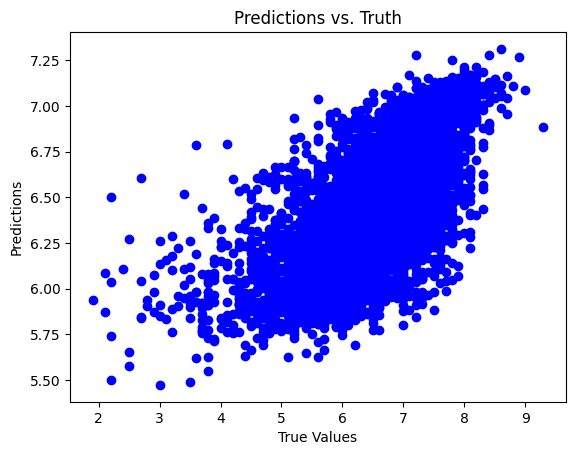

Mean squared error: 0.71
Mean absolute error: 0.65
Coefficient of determination: 0.28


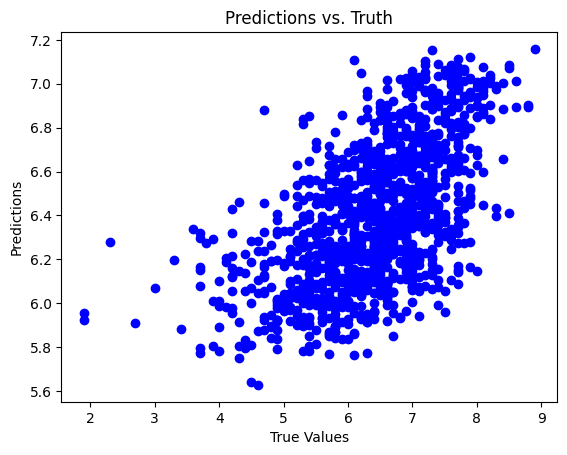

In [20]:
evaluate(forest, X_train, y_train)
evaluate(forest, X_test, y_test)

## Gradient Boosting

In [21]:
from sklearn.ensemble import GradientBoostingRegressor

gradient_boosting_models = []

for lr in tqdm(range(10)):
    for loss in ['squared_error', 'absolute_error', 'huber', 'quantile']:
        for criterion in ['friedman_mse', 'squared_error']:
            for n_estimators in (range(1, 10)):
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
                
                gradient_boosting = GradientBoostingRegressor(learning_rate= 10**-lr, criterion=criterion, loss=loss, n_estimators=n_estimators**2)
                gradient_boosting = gradient_boosting.fit(X_train, y_train)

                gradient_boosting_models.append(((f"gradient_boosting{lr}, {criterion}, {loss}, {n_estimators}", gradient_boosting), mean_squared_error(y_test, gradient_boosting.predict(X_test))))

# add the top 10 gradient boosting models to the list of models
gradient_boosting_models.sort(key=lambda x: x[1])  
for model in gradient_boosting_models[:10]:
    models.append(model[0])

100%|██████████| 10/10 [06:10<00:00, 37.09s/it]


Mean squared error: 2.40
Mean absolute error: 1.27
Coefficient of determination: -1.55


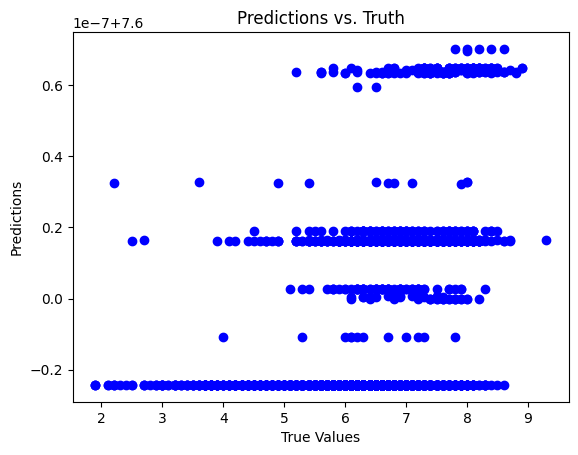

Mean squared error: 2.29
Mean absolute error: 1.24
Coefficient of determination: -1.56


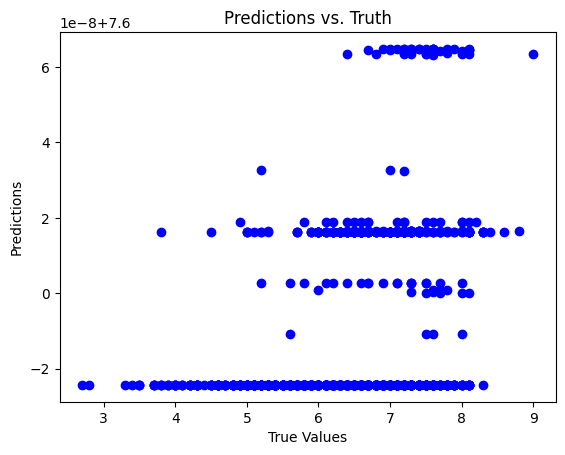

In [22]:
evaluate(gradient_boosting, X_train, y_train)
evaluate(gradient_boosting, X_test, y_test)

## MLP

In [ ]:
from sklearn.neural_network import MLPRegressor

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    mlp = MLPRegressor(hidden_layer_sizes=64, activation='logistic', solver='sgd', alpha=0, batch_size=1, learning_rate_init=.01, shuffle=True, momentum=0, n_iter_no_change=50, max_iter=250)
    mlp = mlp.fit(X_train, y_train)

    models.append((f"mlp{i}", mlp))

In [ ]:
evaluate(mlp, X_train, y_train)
evaluate(mlp, X_test, y_test)

## KNN

In [24]:
from sklearn.neighbors import KNeighborsRegressor

knn_models = []

hyperparameters = set()
for n_neighbors in range(1, 11, 2):
    for weights in ['uniform', 'distance']:
        for algorithm in ['auto', 'ball_tree', 'kd_tree', 'brute']:
            for leaf_size in range(1, 11, 2):
                for p in range(1, 5):
                    hyperparameters.add((n_neighbors, weights, algorithm, leaf_size, p))

n_iters = 0

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    knn = KNeighborsRegressor()
    knn = knn.fit(X_train, y_train)

    n_iters += 1
    knn_models.append(((f"knn{n_iters}", knn), mean_squared_error(y_test, knn.predict(X_test))))

for n_neighbors, weights, algorithm, leaf_size, p in tqdm(hyperparameters):
    knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm, leaf_size=leaf_size, p=p)
    knn = knn.fit(X_train, y_train)
    n_iters += 1
    knn_models.append(((f"knn{n_iters}", knn), mean_squared_error(y_test, knn.predict(X_test))))

# add the top 10 knn models to the list of models
knn_models.sort(key=lambda x: x[1])
for model in knn_models[:10]:
    models.append(model[0])

100%|██████████| 800/800 [05:24<00:00,  2.47it/s]


Mean squared error: 0.00
Mean absolute error: 0.00
Coefficient of determination: 1.00


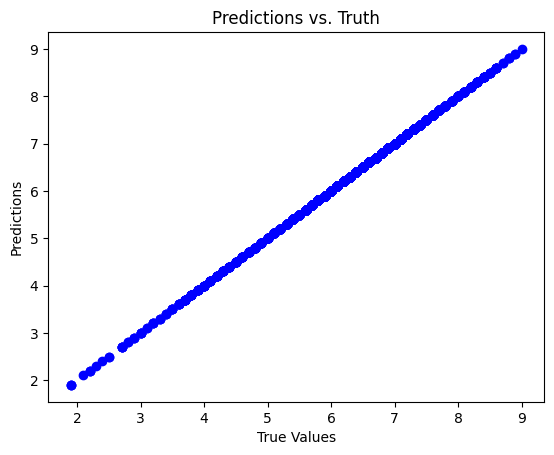

Mean squared error: 0.99
Mean absolute error: 0.76
Coefficient of determination: -0.11


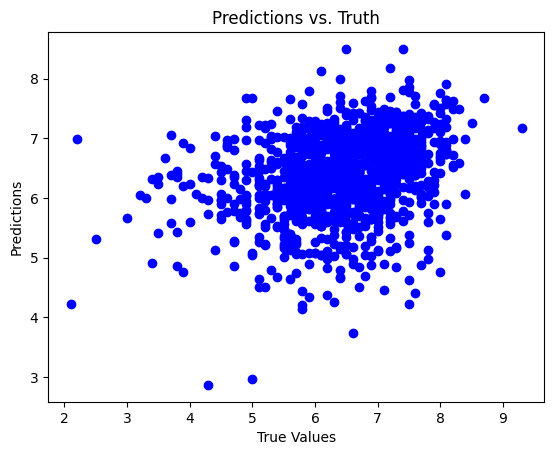

In [25]:
evaluate(knn, X_train, y_train)
evaluate(knn, X_test, y_test)

## Clustering

In [ ]:
from sklearn.cluster import KMeans

hyperparameters = set()

for n_clusters in range(1, 11):
    for init in ['k-means++', 'random']:
        for n_init in range(1, 11):
            for max_iter in range(1, 11):
                for tol in range(1, 11):
                    hyperparameters.add((n_clusters, init, n_init, max_iter, tol))

n_iters = 0

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    kmeans = KMeans()
    kmeans = kmeans.fit(X_train)

    n_iters += 1
    models.append((f"kmeans{n_iters}", kmeans))

for n_clusters, init, n_init, max_iter, tol in tqdm(hyperparameters):
    kmeans = KMeans(n_clusters=n_clusters, init=init, n_init=n_init, max_iter=max_iter, tol=tol)
    kmeans = kmeans.fit(X_train)
    n_iters += 1
    models.append((f"kmeans{n_iters}", kmeans))

In [ ]:
evaluate(kmeans, X_train, y_train)
evaluate(kmeans, X_test, y_test)

# Ensemble

### Voting Regressor

In [30]:
# Ensemble
from sklearn.ensemble import VotingRegressor

def weight(model):
    return 1/mean_squared_error(model.predict(X_test), y_test)

ereg = VotingRegressor(estimators=models, weights=[weight(model[1]) for model in models])
ereg = ereg.fit(X_train, y_train)

Mean squared error: 0.46
Mean absolute error: 0.51
Coefficient of determination: 0.51


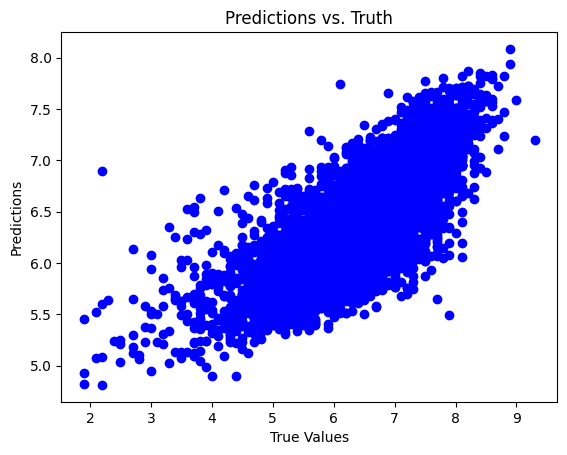

Mean squared error: 0.56
Mean absolute error: 0.58
Coefficient of determination: 0.38


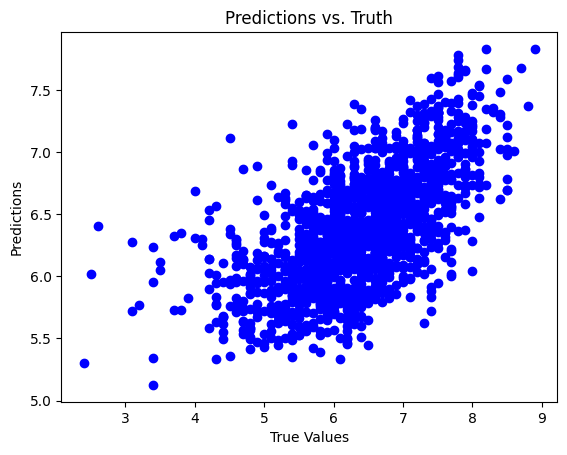

In [31]:
evaluate(ereg, X, y)
evaluate(ereg, X_test_final, y_test_final)

### Stacking 

In [32]:
# Ensemble
from sklearn.ensemble import StackingRegressor

stack = StackingRegressor(estimators=models, final_estimator=LinearRegression())
stack = stack.fit(X_train, y_train)

Mean squared error: 0.26
Mean absolute error: 0.37
Coefficient of determination: 0.72


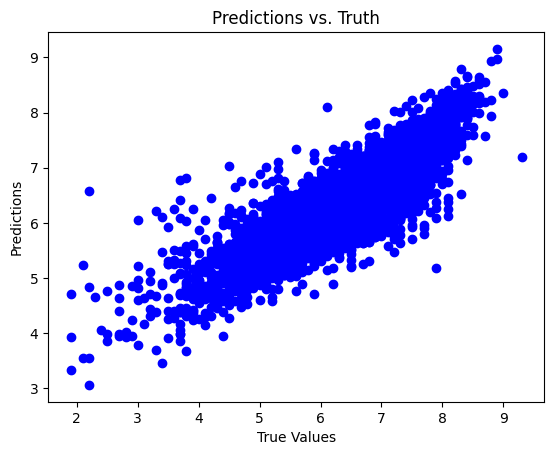

Mean squared error: 0.52
Mean absolute error: 0.55
Coefficient of determination: 0.42


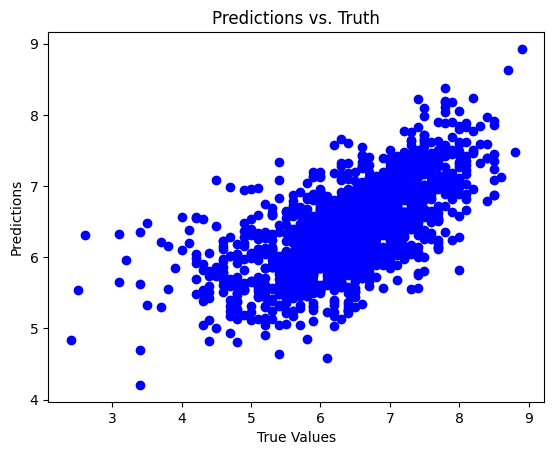

In [33]:
evaluate(stack, X, y)
evaluate(stack, X_test_final, y_test_final)

In [52]:
print("Wonka Score:", stack.predict(poly.fit_transform(wonka.values.reshape(1, -1)))[0])

Wonka Score: 6.832082377058692
